Import data

In [2]:
import pandas as pd
df = pd.read_csv("UBS_Cleaned_Date.csv").iloc[2:, :].reset_index(drop = True)

Remove the first 14 rows and the last row (we don't have future data in the present)

In [3]:
df = df.iloc[14:-1, :].reset_index(drop = True)
df["Wiki Move"] = df["Wiki Move"].astype(int)
df["Goog ROC"] = df["Goog ROC"].astype(float)

KeyError: 'Wiki Move'

Remove the columns that are used to calculate features


<br>
These columns need to be removed for the following reasons:<br>
Open, Close, High, Low................. reflected in features<br>
Gain, Loss............................. reflected in Change in Close<br>
Average Gain, Average Loss............. reflected in RS<br>
RS..................................... reflected in 14-day Price RSI<br>
Wiki Traffic, Wiki Traffic- 1 Day Lag.. reflected in Wiki features<br>
PE Ratio............................... ignore this feature entirely<br>
Wiki 5day disparity.................... reflected in Wiki 5day Disparity Move<br>
Wiki MA3 Move.......................... reflected in Wiki 3day Disparity<br>
Wiki MA5 Move.......................... reflected in Wiki EMA5 Move<br>
Goog Total............................. reflected in Goog features<br>
Goog Gain, Goog Loss................... reflected in Change in Goog<br>
Goog Avg. Gain, Goog Avg. Loss......... reflected in RS<br>
Goog RS................................ reflected in Change in Goog<br>
Goog ROC............................... reflected in Goog ROC Move<br>
Goog MA3............................... reflected in Goog 3day Disparity<br>
Goog EMA5.............................. reflected in Goog EMA5 Move<br>
Goog 3day Disparity.................... reflected in Goog 3day Disparity Move<br>
Goog RSI (14 days)..................... reflected in Goog RSI Move<br>
Price RSI (14 days).................... reflected in Price RSI Move<br>


In [3]:
open_prices = df["Open"]

In [4]:
df.drop(columns = ["Open", "High", "Low", "Gain", "Loss", \
                   "Average Gain", "Average Loss", "RS", "Wiki Traffic", \
                   "Wiki Traffic- 1 Day Lag", "PE Ratio", "Wiki 5day disparity", \
                   "Wiki MA3 Move", "Wiki MA5 Move", "Goog Total", "Goog Gain", \
                   "Goog Loss", "Goog Avg. Gain", "Goog Avg. Loss", "Goog RS", \
                   "Goog ROC", "Goog MA3", "Goog EMA5", "Goog 3day Disparity", \
                   "Goog RSI (14 days)", "Price RSI (14 days)"], inplace = True)

Fix column data format

In [5]:
df["Stochastic Oscillator (14 days)"] = df["Stochastic Oscillator (14 days)"].astype(float)

Train/test split

In [6]:
X = df.iloc[:, 2:-1]
Y = df.iloc[:, -1]

In [7]:
def dataset_split(X, Y, test_size):
    ind = int((1 - test_size) * len(X))
    X_train = X.iloc[:ind, :]
    X_test = X.iloc[ind:, :]
    Y_train = Y.iloc[:ind]
    Y_test = Y.iloc[ind:]
    return X_train, X_test, Y_train, Y_test, ind

In [8]:
X_train, X_test, Y_train, Y_test, split_ind = dataset_split(X, Y, test_size = 0.2)

Analyze the balance of the classification problem<br>
i.e. the percentage of 1s and 0s in the target

In [9]:
counts = Y_train.groupby(by = Y_train).count()
counts = pd.Series(counts)
print(counts)

Target
0.0    300
1.0    328
Name: Target, dtype: int64


Feature scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), columns = X.columns)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns = X.columns)

Each feature's correlation with every other feature

In [11]:
corr_matrix = X_train_sc.corr()

Each feature's correlation with the target variable

In [12]:
feature_target_corr = X_train_sc.corrwith(Y_train, method = "pearson")
feature_target_corr = feature_target_corr.sort_values(ascending = False)

Select features based on correlation

In [13]:
all_features = X.columns.to_list()
selected_features = all_features[:]
for i in range(0, len(corr_matrix)):
    for j in range(i, len(corr_matrix)):
        # Process every pair of features
        corr = corr_matrix.iloc[i, j] 
        if abs(corr) > 0.5 and corr != 1:
            feature1 = all_features[i]
            feature2 = all_features[j]
            
            # Out of the two features in the current pair, remove the feature that
            # is less correlated with the target variable
            corr1 = feature_target_corr[feature1]
            corr2 = feature_target_corr[feature2]
            try:
                if abs(corr1) < abs(corr2):
                    selected_features.remove(feature1)
                    print("Removed from list of features:", feature1)
                else:
                    selected_features.remove(feature2)
                    print("Removed from list of features:", feature2)
            except ValueError:
                # Catch the error just in case we're trying to remove a feature
                # that's already been removed
                pass

Removed from list of features: Wiki 5day Disparity Move
Removed from list of features: Wiki 3day Disparity
Removed from list of features: Wiki EMA5 Move
Removed from list of features: Google_Move
Removed from list of features: Goog MA5
Removed from list of features: Goog 3day Disparity Move


In [14]:
X_train_tr = X_train_sc[selected_features]
X_test_tr = X_test_sc[selected_features]

In [15]:
corr_matrix_selected_features = X_train_tr.corr()

Plot number of components vs. explained variance for PCA algorithm

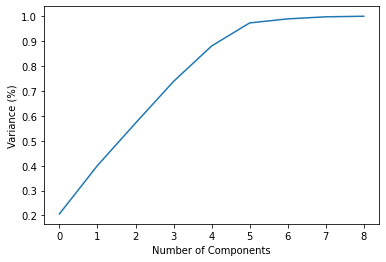

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
pca = PCA().fit(X_train_tr)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()

Run PCA algorithm (the optimal number of components is wherever the elbow in the graph occurs)

In [17]:
pca = PCA(n_components = 5).fit(X_train_tr.to_numpy())
X_train_pca = pca.transform(X_train_tr.to_numpy())
X_test_pca = pca.transform(X_test_tr.to_numpy())

Model =======================================================================================

In [18]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth = 4, random_state = 0)
model.fit(X_train_pca, Y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

Make predictions

In [19]:
Y_test_pred = pd.Series(model.predict(X_test_pca)).astype(int)
Y_train_pred = pd.Series(model.predict(X_train_pca)).astype(int)

In [20]:
from sklearn.metrics import classification_report
report = classification_report(Y_test_pred, Y_test, target_names = ["be flat", "be long"], output_dict = True)
report = pd.DataFrame(report).T
print(report)
print("")

              precision    recall  f1-score     support
be flat        0.416667  0.545455  0.472441   55.000000
be long        0.705882  0.588235  0.641711  102.000000
accuracy       0.573248  0.573248  0.573248    0.573248
macro avg      0.561275  0.566845  0.557076  157.000000
weighted avg   0.604565  0.573248  0.582413  157.000000



Tree diagram

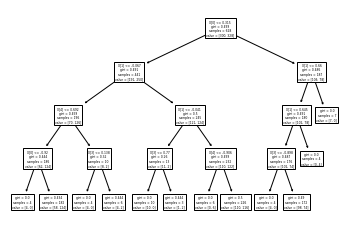

In [21]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots()
plot_tree(model, ax = plt.axes())
plt.show()

Evaluate model

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

Print metrics

In [23]:
metrics = \
[ \
[accuracy_score(Y_train, Y_train_pred), accuracy_score(Y_test, Y_test_pred)],
[precision_score(Y_train, Y_train_pred), precision_score(Y_test, Y_test_pred)], [recall_score(Y_train, Y_train_pred), recall_score(Y_test, Y_test_pred)],
[f1_score(Y_train, Y_train_pred), f1_score(Y_test, Y_test_pred)]
]
metrics = np.array(metrics) * 100

In [24]:
metrics = pd.DataFrame(metrics, columns = ["Training Set", "Test Set"])
metrics.insert(0, "Metric", ["Accuracy", "Precision", "Recall", "F1 Score"])
metrics.set_index("Metric", inplace = True)
print(metrics)

           Training Set   Test Set
Metric                            
Accuracy      60.987261  57.324841
Precision     59.857482  58.823529
Recall        76.829268  70.588235
F1 Score      67.289720  64.171123
